<a href="https://colab.research.google.com/github/felixyuzhenyang/MSSP-6070-YuzhenYang/blob/main/PARTICIPATION_ACTIVITY_Week_8_Yuzhen_Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setting Working Environment.

In [11]:
# !rm -rf /content/*

In [12]:
from google.colab import userdata
import os
os.chdir('/content')
github_token = userdata.get('GitHub_MSSP6070')
owner = 'felixyuzhenyang'
repository = 'MSSP-6070-YuzhenYang'

clone_url = f'https://{github_token}@github.com/{owner}/{repository}.git'

!git clone {clone_url}

Cloning into 'MSSP-6070-YuzhenYang'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 252 (delta 36), reused 14 (delta 9), pack-reused 189 (from 1)
Receiving objects: 100% (252/252), 7.13 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pathlib import Path

working_directory = '/content/MSSP-6070-YuzhenYang/data'
try:
    os.chdir(working_directory)
    print(f"New working path successfully set: {os.getcwd()}")
except FileNotFoundError:
    print(f"error: path not exist: {working_directory}")

df = pd.read_csv('InternetSales.csv', encoding="latin1", low_memory=False)

New working path successfully set: /content/MSSP-6070-YuzhenYang/data


## 1. Forecast

Note: As I was doing Assignment 2, I noticed that the data set starts at 12/29/2010 and ends at 01/28/2014, so there are very few observations in the years 2010 and 2014. As a result, the sales amount in these years is very low (leading to a somewhat weird figure). To ensure the accuracy of our forecasting, I decided to exclude the data from 2010 and 2014. This means I use data from 2011, 2012, and 2013 to generate the forecast.

In [14]:
# Internet Sales Forecast

df["OrderDate"] = pd.to_datetime(df["OrderDate"], errors="coerce")
df = df.dropna(subset=["OrderDate"]).copy()

# keep year 2011–2013
df = df[(df["OrderDate"].dt.year >= 2011) & (df["OrderDate"].dt.year <= 2013)].copy()

sales_col = "SalesAmount"
prod_col = "EnglishProductName"
if sales_col not in df.columns:
    raise ValueError("cannot find column: SalesAmount.")
if prod_col not in df.columns:
    raise ValueError("Column EnglishProductName not found.")

monthly = (
    df.groupby(pd.Grouper(key="OrderDate", freq="M"))[sales_col]
      .sum()
      .astype(float)
)

monthly = monthly[monthly > 0]

/tmp/ipython-input-3842128536.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="OrderDate", freq="M"))[sales_col]


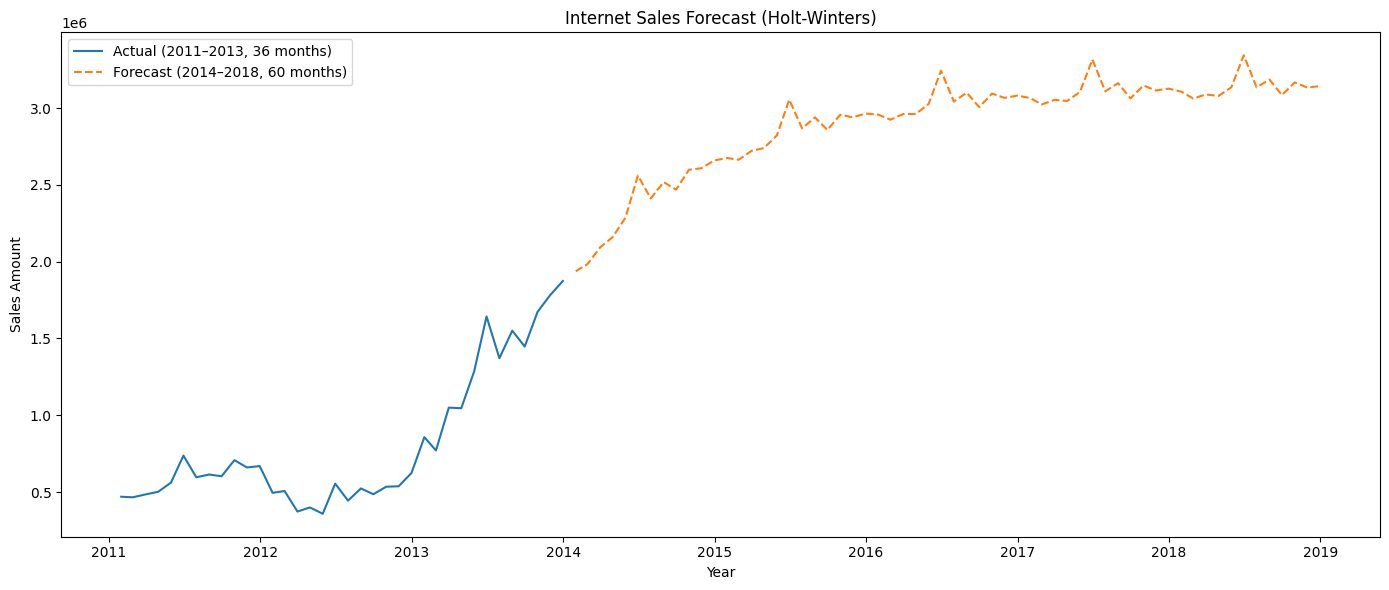

saved: forecast_next_5_years_monthly_2011_2013.csv


In [15]:
# we use Holt-Winters model for forecasting to capture long-term trends and seasonal fluctuations.
hw_model = ExponentialSmoothing(
    monthly,
    trend="add",
    damped_trend=True,
    seasonal="add",
    seasonal_periods=12,
    initialization_method="estimated"
).fit(optimized=True, use_brute=True)

forecast_horizon = 60
forecast = hw_model.forecast(forecast_horizon)

# visualization & save
plt.figure(figsize=(14,6))
plt.plot(monthly.index, monthly.values, label="Actual (2011–2013, 36 months)")
plt.plot(forecast.index, forecast.values, linestyle="--", label="Forecast (2014–2018, 60 months)")
plt.title("Internet Sales Forecast (Holt-Winters)")
plt.xlabel("Year")
plt.ylabel("Sales Amount")
plt.legend()
plt.tight_layout()
plt.show()

forecast_tbl = pd.DataFrame({
    "Month": forecast.index.strftime("%Y-%m"),
    "ForecastSales": forecast.values
})
forecast_tbl.to_csv("forecast_5_years_monthly_2011_2013.csv", index=False)
print("saved: forecast_next_5_years_monthly_2011_2013.csv")

In [16]:
# core summary
summary = {
    "training_months": int(len(monthly)),
    "first_training_month": str(monthly.index[0].strftime("%Y-%m")),
    "last_training_month": str(monthly.index[-1].strftime("%Y-%m")),
    "first_forecast_month": str(forecast.index[0].strftime("%Y-%m")),
    "last_forecast_month": str(forecast.index[-1].strftime("%Y-%m")),
    "avg_predicted_monthly_sales": float(np.mean(forecast.values)),
    "min_predicted_monthly_sales": float(np.min(forecast.values)),
    "max_predicted_monthly_sales": float(np.max(forecast.values)),
}
print(summary)

{'training_months': 36, 'first_training_month': '2011-01', 'last_training_month': '2013-12', 'first_forecast_month': '2014-01', 'last_forecast_month': '2018-12', 'avg_predicted_monthly_sales': 2898938.160482464, 'min_predicted_monthly_sales': 1937806.18518942, 'max_predicted_monthly_sales': 3343557.835054649}


## 2. Which product will generate the most sales?

/tmp/ipython-input-1097710677.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key="OrderDate", freq="M"), prod_col])[sales_col]
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._in


=== Predicted Top-Selling Product (2014–2018) ===
Mountain-200 Silver, 38 — total forecasted sales: 23771737.13
Saved: product_forecast_5yrs.csv


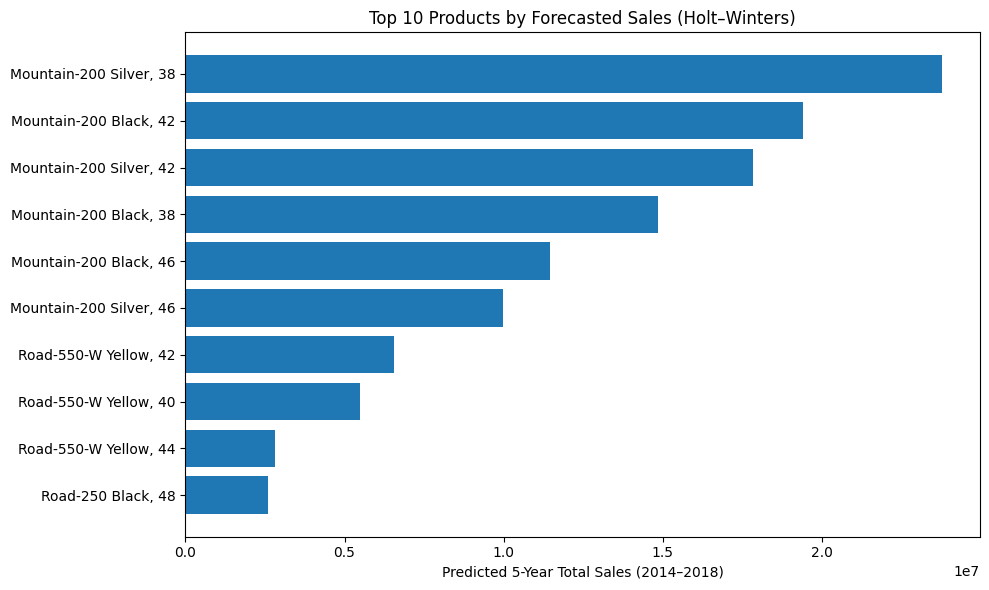

In [17]:
monthly_prod = (
    df.groupby([pd.Grouper(key="OrderDate", freq="M"), prod_col])[sales_col]
      .sum()
      .reset_index()
)

# define a forecasting function for each product
def forecast_product_sales(subdf):
    subdf = subdf.sort_values("OrderDate")
    monthly = subdf.set_index("OrderDate")[sales_col]
    if len(monthly) < 24 or monthly.sum() <= 0:
        return None
    try:
        model = ExponentialSmoothing(
            monthly,
            trend="add",
            damped_trend=True,
            seasonal="add",
            seasonal_periods=12,
            initialization_method="estimated"
        ).fit(optimized=True, use_brute=True)
        forecast = model.forecast(60)
        return forecast.sum()
    except Exception:
        return None

# forecast use the function
results = []
for prod, subdf in monthly_prod.groupby(prod_col):
    fsum = forecast_product_sales(subdf)
    if fsum is not None:
        results.append({"Product": prod, "Forecast5yrTotal": fsum})

forecast_results = pd.DataFrame(results).dropna().sort_values("Forecast5yrTotal", ascending=False)

# top-selling product
top_prod = forecast_results.iloc[0]
print("\n=== Predicted Top-Selling Product (2014–2018) ===")
print(f"{top_prod['Product']} — total forecasted sales: {top_prod['Forecast5yrTotal']:.2f}")

# Save results & plot Top10
forecast_results.to_csv("product_forecast_5yrs.csv", index=False)
print("Saved: product_forecast_5yrs.csv")

top10 = forecast_results.head(10)
plt.figure(figsize=(10,6))
plt.barh(top10["Product"], top10["Forecast5yrTotal"])
plt.xlabel("Predicted 5-Year Total Sales (2014–2018)")
plt.title("Top 10 Products by Forecasted Sales (Holt–Winters)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


According to the forecast, mountain bikes (specifically, Mountain-200 Silver, 38) will generate the most sales.